# ColonFormer Inference Notebook

Notebook này cho phép bạn sử dụng model ColonFormer đã được huấn luyện để:
- Test trên tập dữ liệu test có sẵn
- Upload và test ảnh riêng
- Xem kết quả phân đoạn và metrics
- So sánh với ground truth

## 1. Import Libraries và Setup

In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from glob import glob
from tqdm import tqdm
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Import model
from mmseg.models.segmentors import ColonFormer as UNet

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set matplotlib style
plt.style.use('default')
sns.set_palette("husl")

Using device: cuda


## 2. Define Helper Functions

In [13]:
# Evaluation metrics
epsilon = 1e-7

def dice_coeff(y_true, y_pred):
    """Tính Dice coefficient"""
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + epsilon)

def iou_score(y_true, y_pred):
    """Tính IoU score"""
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / (union + epsilon)

def precision_score(y_true, y_pred):
    """Tính Precision"""
    true_positives = np.sum(y_true * y_pred)
    predicted_positives = np.sum(y_pred)
    return true_positives / (predicted_positives + epsilon)

def recall_score(y_true, y_pred):
    """Tính Recall"""
    true_positives = np.sum(y_true * y_pred)
    possible_positives = np.sum(y_true)
    return true_positives / (possible_positives + epsilon)

def preprocess_image(image_path, target_size=(352, 352)):
    """Tiền xử lý ảnh đầu vào"""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_shape = image.shape[:2]
    
    # Resize
    image_resized = cv2.resize(image, target_size)
    
    # Normalize
    image_normalized = image_resized.astype('float32') / 255.0
    
    # Convert to tensor
    image_tensor = torch.from_numpy(image_normalized.transpose((2, 0, 1))).unsqueeze(0)
    
    return image_tensor, image, original_shape

def postprocess_mask(mask_tensor, original_shape):
    """Hậu xử lý mask đầu ra"""
    mask = mask_tensor.sigmoid().data.cpu().numpy().squeeze()
    mask = cv2.resize(mask, (original_shape[1], original_shape[0]))
    mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)
    return mask

## 3. Load Pre-trained Model

In [14]:
# Model configuration
BACKBONE = 'b1'  # Change này nếu sử dụng backbone khác
MODEL_PATH = './snapshots/ColonFormerB3/last.pth'  # Đường dẫn đến model đã train

def load_model(model_path, backbone='b3'):
    """Load model đã được train"""
    # Initialize model
    model = UNet(
        backbone=dict(
            type='mit_{}'.format(backbone),
            style='pytorch'
        ),
        decode_head=dict(
            type='UPerHead',
            in_channels=[64, 128, 320, 512],
            in_index=[0, 1, 2, 3],
            channels=128,
            dropout_ratio=0.1,
            num_classes=1,
            norm_cfg=dict(type='BN', requires_grad=True),
            align_corners=False,
            decoder_params=dict(embed_dim=768),
            loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0)
        ),
        neck=None,
        auxiliary_head=None,
        train_cfg=dict(),
        test_cfg=dict(mode='whole'),
        pretrained=None
    ).to(device)
    
    # Load weights
    if os.path.exists(model_path):
        checkpoint = torch.load(model_path, map_location=device)
        if 'state_dict' in checkpoint:
            model.load_state_dict(checkpoint['state_dict'])
            print(f"✅ Loaded checkpoint from epoch {checkpoint.get('epoch', 'unknown')}")
        else:
            model.load_state_dict(checkpoint)
            print("✅ Loaded model weights")
    else:
        print(f"❌ Model file not found: {model_path}")
        return None
    
    model.eval()
    return model

# Load model
model = load_model(MODEL_PATH, BACKBONE)
if model is not None:
    total_params = sum(p.numel() for p in model.parameters())
    print(f"📊 Model loaded successfully with {total_params:,} parameters")

✅ Loaded checkpoint from epoch 21
📊 Model loaded successfully with 22,023,824 parameters


## 4. Visualization Functions

In [15]:
def visualize_results(image, pred_mask, gt_mask=None, title="Prediction Results"):
    """Hiển thị kết quả dự đoán"""
    if gt_mask is not None:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Original image
        axes[0, 0].imshow(image)
        axes[0, 0].set_title('Ảnh Gốc')
        axes[0, 0].axis('off')
        
        # Ground truth
        axes[0, 1].imshow(gt_mask, cmap='gray')
        axes[0, 1].set_title('Ground Truth')
        axes[0, 1].axis('off')
        
        # Prediction
        axes[1, 0].imshow(pred_mask, cmap='gray')
        axes[1, 0].set_title('Dự Đoán')
        axes[1, 0].axis('off')
        
        # Overlay
        overlay = image.copy()
        pred_binary = (pred_mask > 0.5).astype(np.uint8)
        overlay[pred_binary == 1] = [255, 0, 0]  # Red for prediction
        axes[1, 1].imshow(overlay)
        axes[1, 1].set_title('Overlay (Đỏ: Dự đoán)')
        axes[1, 1].axis('off')
        
    else:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image
        axes[0].imshow(image)
        axes[0].set_title('Ảnh Gốc')
        axes[0].axis('off')
        
        # Prediction
        axes[1].imshow(pred_mask, cmap='gray')
        axes[1].set_title('Dự Đoán')
        axes[1].axis('off')
        
        # Overlay
        overlay = image.copy()
        pred_binary = (pred_mask > 0.5).astype(np.uint8)
        overlay[pred_binary == 1] = [255, 0, 0]  # Red for prediction
        axes[2].imshow(overlay)
        axes[2].set_title('Overlay (Đỏ: Dự đoán)')
        axes[2].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_metrics(dice, iou, precision, recall):
    """Vẽ biểu đồ metrics"""
    metrics = ['Dice', 'IoU', 'Precision', 'Recall']
    values = [dice, iou, precision, recall]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics, values, color=colors, alpha=0.8)
    plt.ylim(0, 1)
    plt.title('Kết Quả Đánh Giá', fontsize=16, fontweight='bold')
    plt.ylabel('Score')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

## 5. Test Single Image Function

In [16]:
def test_single_image(image_path, mask_path=None, show_results=True):
    """Test một ảnh đơn lẻ"""
    if not os.path.exists(image_path):
        print(f"❌ Image not found: {image_path}")
        return None
    
    # Preprocess
    image_tensor, original_image, original_shape = preprocess_image(image_path)
    image_tensor = image_tensor.to(device)
    
    # Inference
    with torch.no_grad():
        outputs = model(image_tensor)
        if isinstance(outputs, (list, tuple)):
            pred_mask = outputs[0]  # Take first output
        else:
            pred_mask = outputs
    
    # Postprocess
    pred_mask_np = postprocess_mask(pred_mask, original_shape)
    pred_binary = (pred_mask_np > 0.5).astype(np.float32)
    
    # Load ground truth if available
    gt_mask_np = None
    metrics = None
    
    if mask_path and os.path.exists(mask_path):
        gt_mask = cv2.imread(mask_path, 0)
        gt_mask_np = cv2.resize(gt_mask, (original_shape[1], original_shape[0]))
        gt_mask_np = gt_mask_np.astype(np.float32) / 255.0
        gt_binary = (gt_mask_np > 0.5).astype(np.float32)
        
        # Calculate metrics
        dice = dice_coeff(gt_binary, pred_binary)
        iou = iou_score(gt_binary, pred_binary)
        precision = precision_score(gt_binary, pred_binary)
        recall = recall_score(gt_binary, pred_binary)
        
        metrics = {
            'dice': dice,
            'iou': iou,
            'precision': precision,
            'recall': recall
        }
        
        print(f"📊 Metrics:")
        print(f"   Dice: {dice:.4f}")
        print(f"   IoU: {iou:.4f}")
        print(f"   Precision: {precision:.4f}")
        print(f"   Recall: {recall:.4f}")
    
    # Visualization
    if show_results:
        filename = os.path.basename(image_path)
        visualize_results(original_image, pred_mask_np, gt_mask_np, f"Results: {filename}")
        
        if metrics:
            plot_metrics(metrics['dice'], metrics['iou'], 
                        metrics['precision'], metrics['recall'])
    
    return {
        'prediction': pred_mask_np,
        'binary_prediction': pred_binary,
        'ground_truth': gt_mask_np,
        'metrics': metrics,
        'original_image': original_image
    }

## 6. Random Test từ Tập Dữ Liệu Test


In [17]:
import random
import time

# Định nghĩa paths cho các dataset test
TEST_DATASETS = {
    'Kvasir': {
        'images': './data/TestDataset/Kvasir/images',
        'masks': './data/TestDataset/Kvasir/masks'
    },
    'ETIS-LaribPolypDB': {
        'images': './data/TestDataset/ETIS-LaribPolypDB/images', 
        'masks': './data/TestDataset/ETIS-LaribPolypDB/masks'
    },
    'CVC-ColonDB': {
        'images': './data/TestDataset/CVC-ColonDB/images',
        'masks': './data/TestDataset/CVC-ColonDB/masks'
    },
    'CVC-ClinicDB': {
        'images': './data/TestDataset/CVC-ClinicDB/images',
        'masks': './data/TestDataset/CVC-ClinicDB/masks'
    },
    'CVC-300': {
        'images': './data/TestDataset/CVC-300/images',
        'masks': './data/TestDataset/CVC-300/masks'
    }
}

def get_random_image_from_dataset(dataset_name):
    """Lấy ngẫu nhiên một ảnh từ dataset được chỉ định"""
    if dataset_name not in TEST_DATASETS:
        print(f"❌ Dataset '{dataset_name}' không tồn tại!")
        return None, None
    
    dataset_info = TEST_DATASETS[dataset_name]
    images_path = dataset_info['images']
    masks_path = dataset_info['masks']
    
    # Kiểm tra xem thư mục có tồn tại không
    if not os.path.exists(images_path):
        print(f"❌ Thư mục ảnh không tồn tại: {images_path}")
        return None, None
    
    if not os.path.exists(masks_path):
        print(f"❌ Thư mục mask không tồn tại: {masks_path}")
        return None, None
    
    # Lấy danh sách tất cả ảnh
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
    all_images = []
    for ext in image_extensions:
        all_images.extend(glob(os.path.join(images_path, ext)))
        all_images.extend(glob(os.path.join(images_path, ext.upper())))
    
    if not all_images:
        print(f"❌ Không tìm thấy ảnh nào trong {images_path}")
        return None, None
    
    # Chọn ngẫu nhiên một ảnh
    random_image_path = random.choice(all_images)
    image_name = os.path.basename(random_image_path)
    
    # Tìm mask tương ứng
    mask_name = os.path.splitext(image_name)[0]
    possible_mask_paths = [
        os.path.join(masks_path, f"{mask_name}.png"),
        os.path.join(masks_path, f"{mask_name}.jpg"),
        os.path.join(masks_path, f"{mask_name}.jpeg"),
        os.path.join(masks_path, f"{mask_name}.bmp"),
        os.path.join(masks_path, f"{mask_name}.tiff")
    ]
    
    mask_path = None
    for possible_path in possible_mask_paths:
        if os.path.exists(possible_path):
            mask_path = possible_path
            break
    
    if mask_path is None:
        print(f"⚠️ Không tìm thấy mask cho ảnh {image_name}")
    
    return random_image_path, mask_path

def test_random_image_from_dataset(dataset_name):
    """Test ngẫu nhiên một ảnh từ dataset"""
    print(f"🎲 Đang chọn ngẫu nhiên ảnh từ dataset: {dataset_name}...")
    
    image_path, mask_path = get_random_image_from_dataset(dataset_name)
    
    if image_path is None:
        return None
    
    print(f"📷 Ảnh được chọn: {os.path.basename(image_path)}")
    if mask_path:
        print(f"🎯 Mask tương ứng: {os.path.basename(mask_path)}")
    
    # Đo thời gian inference
    start_time = time.time()
    result = test_single_image(image_path, mask_path, show_results=True)
    end_time = time.time()
    
    print(f"⏱️ Thời gian inference: {end_time - start_time:.3f} giây")
    
    return result

def test_random_from_all_datasets():
    """Test ngẫu nhiên từ tất cả các dataset"""
    print("🌟 Test ngẫu nhiên từ tất cả các dataset...\n")
    
    results = {}
    
    for dataset_name in TEST_DATASETS.keys():
        print(f"\n{'='*50}")
        print(f"📁 DATASET: {dataset_name}")
        print(f"{'='*50}")
        
        result = test_random_image_from_dataset(dataset_name)
        if result:
            results[dataset_name] = result
        
        print("\n" + "-"*30)
    
    # Tóm tắt kết quả
    if results:
        print(f"\n🏆 TÓM TẮT KẾT QUẢ:")
        print(f"{'Dataset':<20} {'Dice':<8} {'IoU':<8} {'Precision':<10} {'Recall':<8}")
        print("-" * 60)
        
        for dataset_name, result in results.items():
            if result['metrics']:
                metrics = result['metrics']
                print(f"{dataset_name:<20} {metrics['dice']:<8.3f} {metrics['iou']:<8.3f} "
                      f"{metrics['precision']:<10.3f} {metrics['recall']:<8.3f}")
    
    return results

def test_multiple_random_images(dataset_name, num_images=3):
    """Test nhiều ảnh ngẫu nhiên từ một dataset"""
    print(f"🎲 Test {num_images} ảnh ngẫu nhiên từ dataset {dataset_name}:\n")
    
    results = []
    for i in range(num_images):
        print(f"\n📷 Ảnh thứ {i+1}/{num_images}:")
        print("-" * 40)
        result = test_random_image_from_dataset(dataset_name)
        if result:
            results.append(result)
    
    # Tính metrics trung bình
    if results:
        valid_metrics = [r['metrics'] for r in results if r['metrics'] is not None]
        if valid_metrics:
            avg_dice = np.mean([m['dice'] for m in valid_metrics])
            avg_iou = np.mean([m['iou'] for m in valid_metrics])
            avg_precision = np.mean([m['precision'] for m in valid_metrics])
            avg_recall = np.mean([m['recall'] for m in valid_metrics])
            
            print(f"\n📊 METRICS TRUNG BÌNH cho {len(valid_metrics)} ảnh:")
            print(f"   Dice: {avg_dice:.4f}")
            print(f"   IoU: {avg_iou:.4f}")
            print(f"   Precision: {avg_precision:.4f}")
            print(f"   Recall: {avg_recall:.4f}")
            
            # Vẽ biểu đồ metrics trung bình
            plot_metrics(avg_dice, avg_iou, avg_precision, avg_recall)
    
    return results

print("✅ Functions loaded successfully!")
print("\n📋 Available functions:")
print("   • test_random_image_from_dataset(dataset_name)")
print("   • test_random_from_all_datasets()")
print("   • test_multiple_random_images(dataset_name, num_images)")
print("\n📁 Available datasets:", list(TEST_DATASETS.keys()))

✅ Functions loaded successfully!

📋 Available functions:
   • test_random_image_from_dataset(dataset_name)
   • test_random_from_all_datasets()
   • test_multiple_random_images(dataset_name, num_images)

📁 Available datasets: ['Kvasir', 'ETIS-LaribPolypDB', 'CVC-ColonDB', 'CVC-ClinicDB', 'CVC-300']


🌟 Test ngẫu nhiên từ tất cả các dataset...


📁 DATASET: Kvasir
🎲 Đang chọn ngẫu nhiên ảnh từ dataset: Kvasir...
📷 Ảnh được chọn: cju5xq3tdm9fn0987pbedxdg5.png
🎯 Mask tương ứng: cju5xq3tdm9fn0987pbedxdg5.png
📊 Metrics:
   Dice: 0.6971
   IoU: 0.5351
   Precision: 0.9520
   Recall: 0.5499


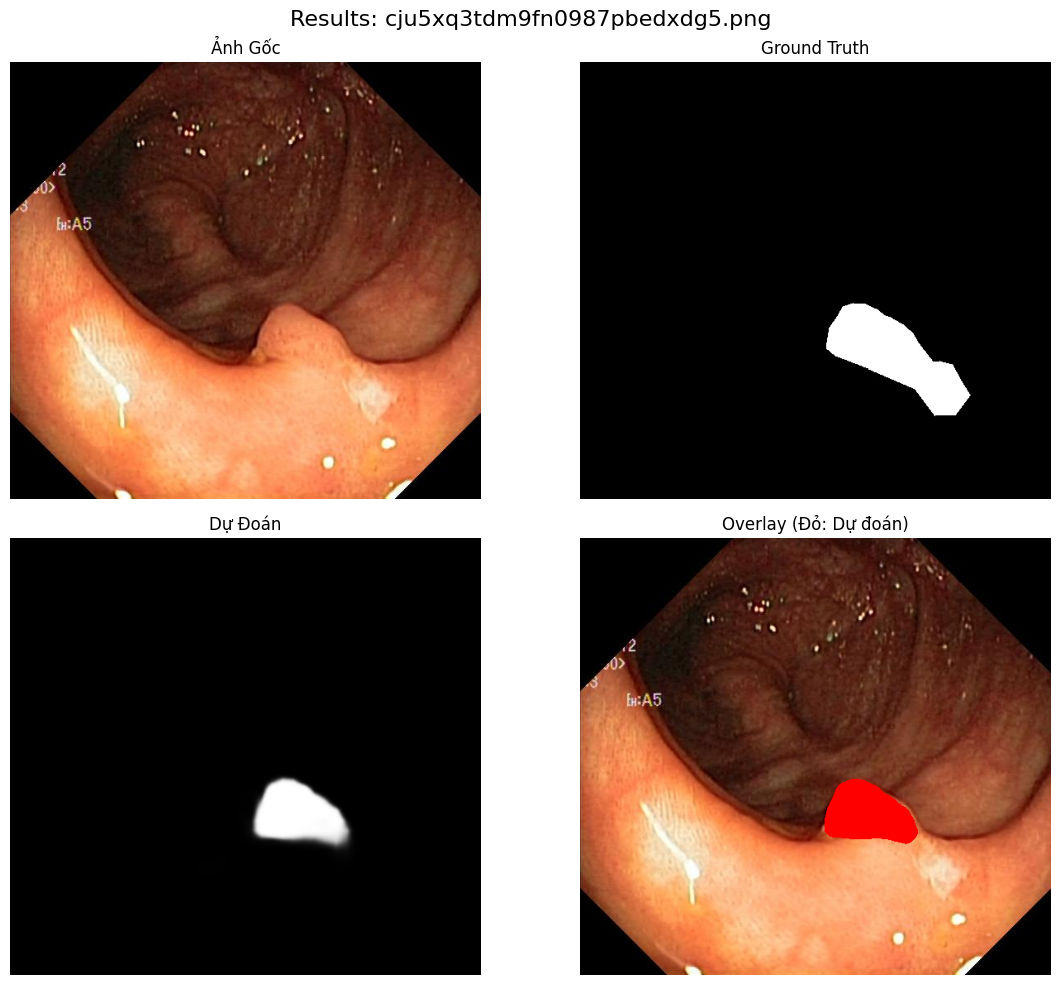

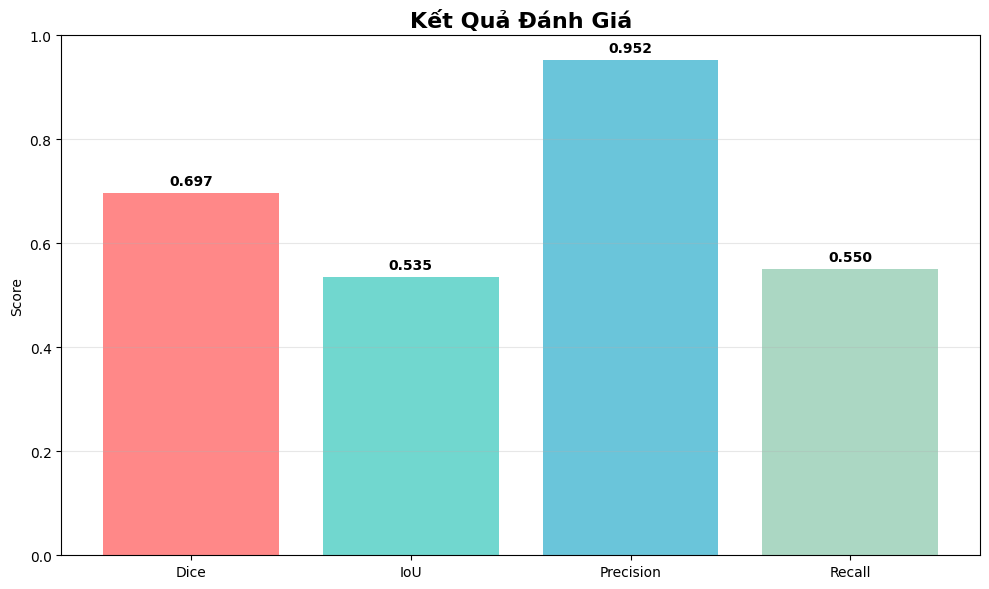

⏱️ Thời gian inference: 1.813 giây

------------------------------

📁 DATASET: ETIS-LaribPolypDB
🎲 Đang chọn ngẫu nhiên ảnh từ dataset: ETIS-LaribPolypDB...
📷 Ảnh được chọn: 15.png
🎯 Mask tương ứng: 15.png
📊 Metrics:
   Dice: 0.7000
   IoU: 0.5384
   Precision: 0.9713
   Recall: 0.5472


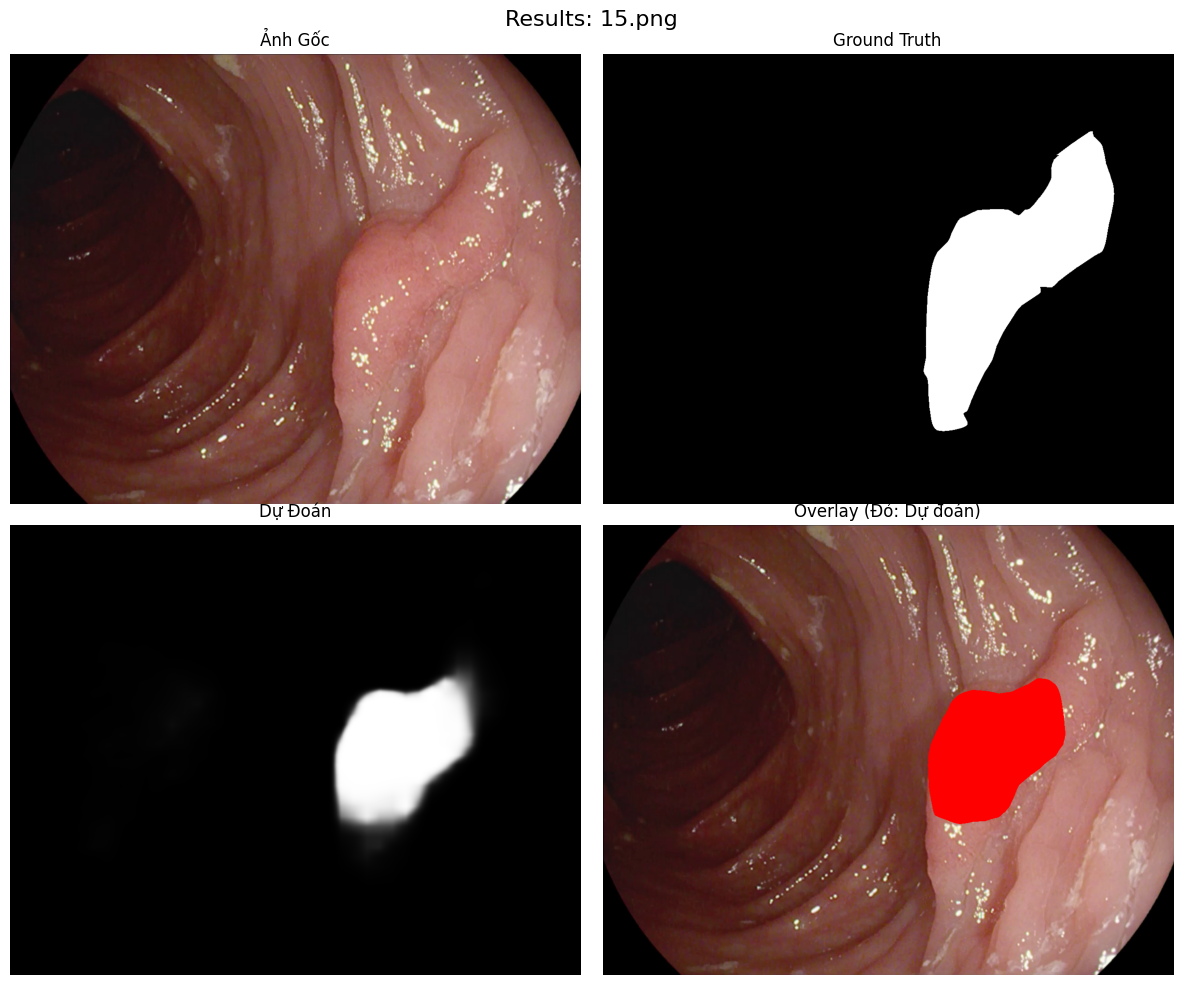

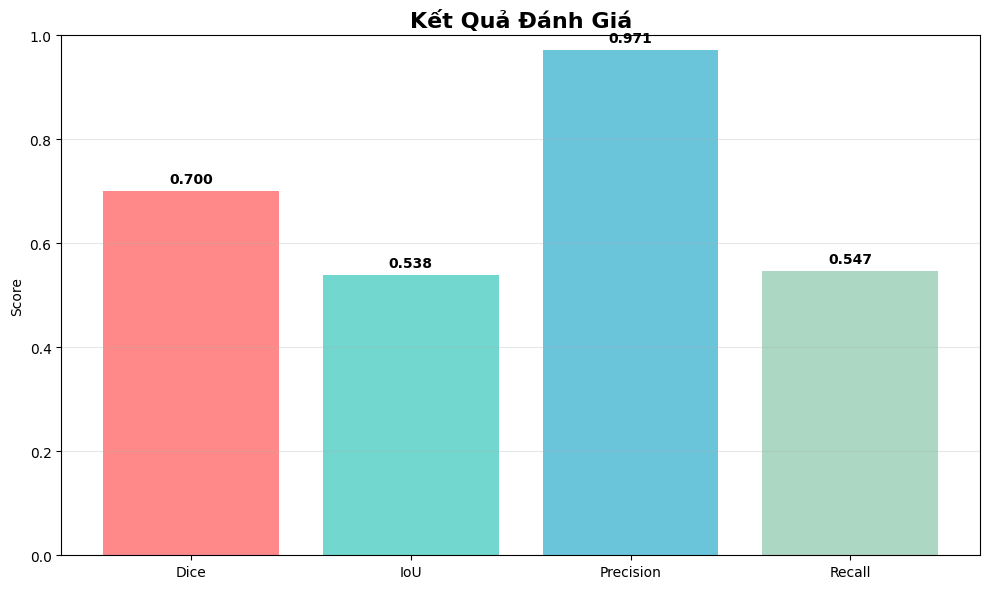

⏱️ Thời gian inference: 1.285 giây

------------------------------

📁 DATASET: CVC-ColonDB
🎲 Đang chọn ngẫu nhiên ảnh từ dataset: CVC-ColonDB...
📷 Ảnh được chọn: 84.png
🎯 Mask tương ứng: 84.png
📊 Metrics:
   Dice: 0.8138
   IoU: 0.6861
   Precision: 0.7249
   Recall: 0.9276


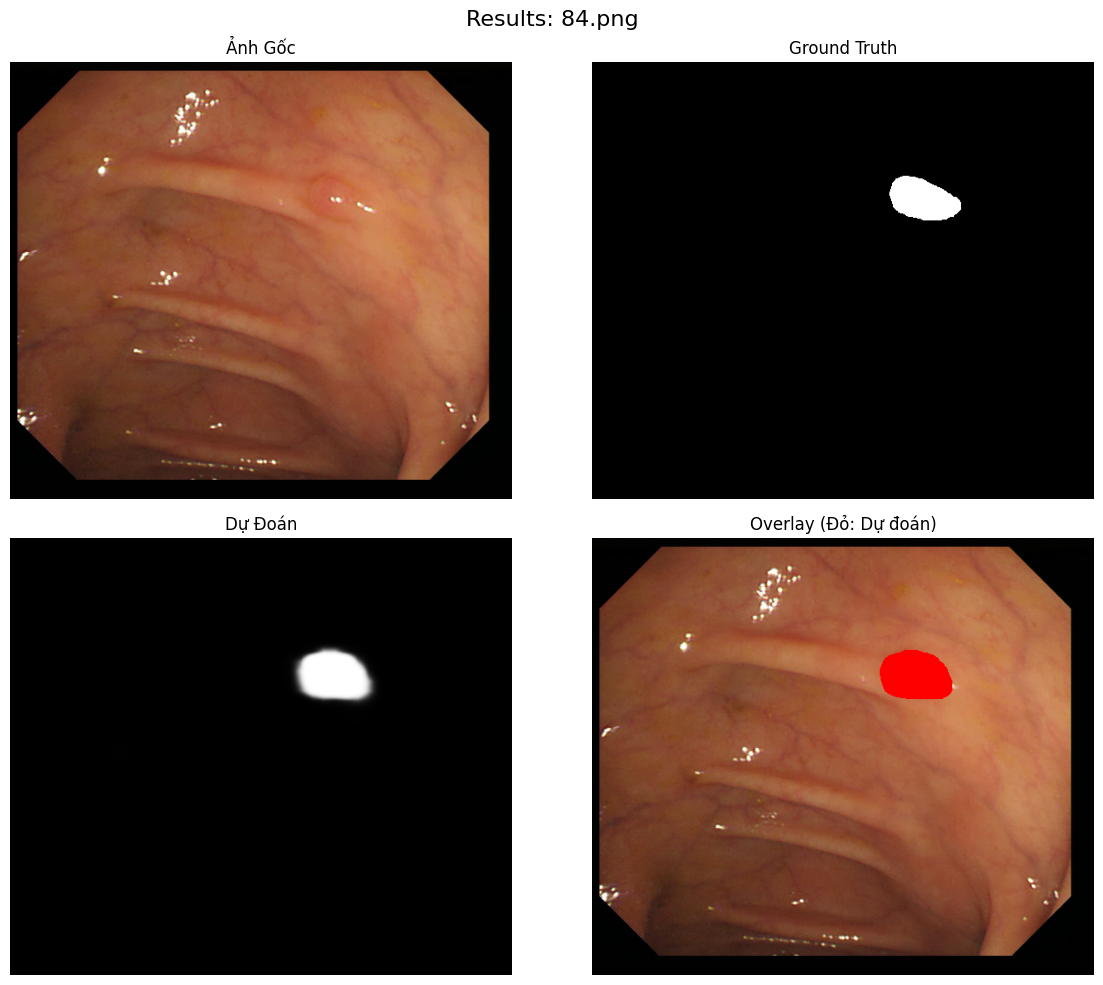

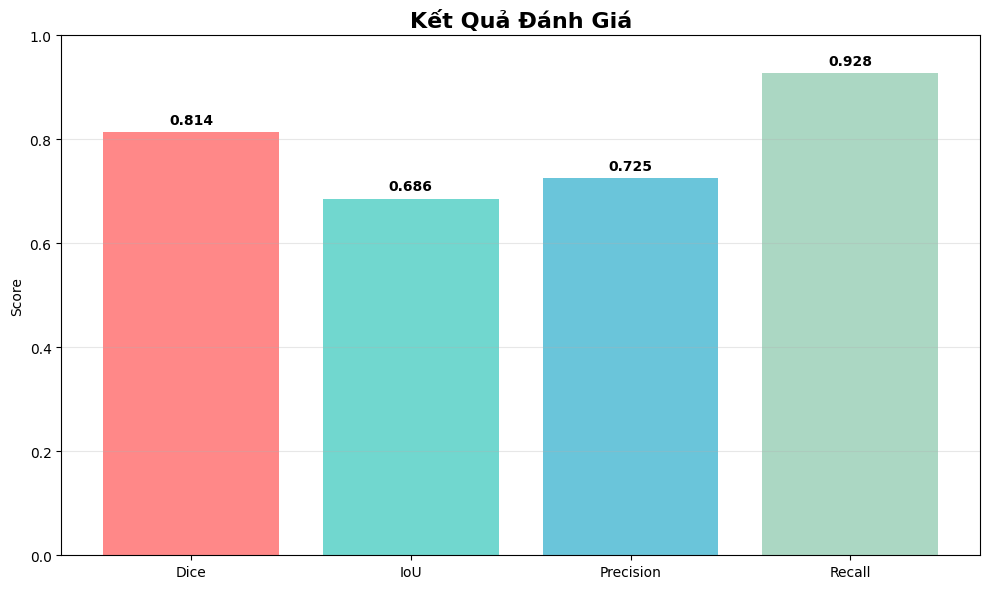

⏱️ Thời gian inference: 0.889 giây

------------------------------

📁 DATASET: CVC-ClinicDB
🎲 Đang chọn ngẫu nhiên ảnh từ dataset: CVC-ClinicDB...
📷 Ảnh được chọn: 481.png
🎯 Mask tương ứng: 481.png
📊 Metrics:
   Dice: 0.9408
   IoU: 0.8883
   Precision: 0.8927
   Recall: 0.9945


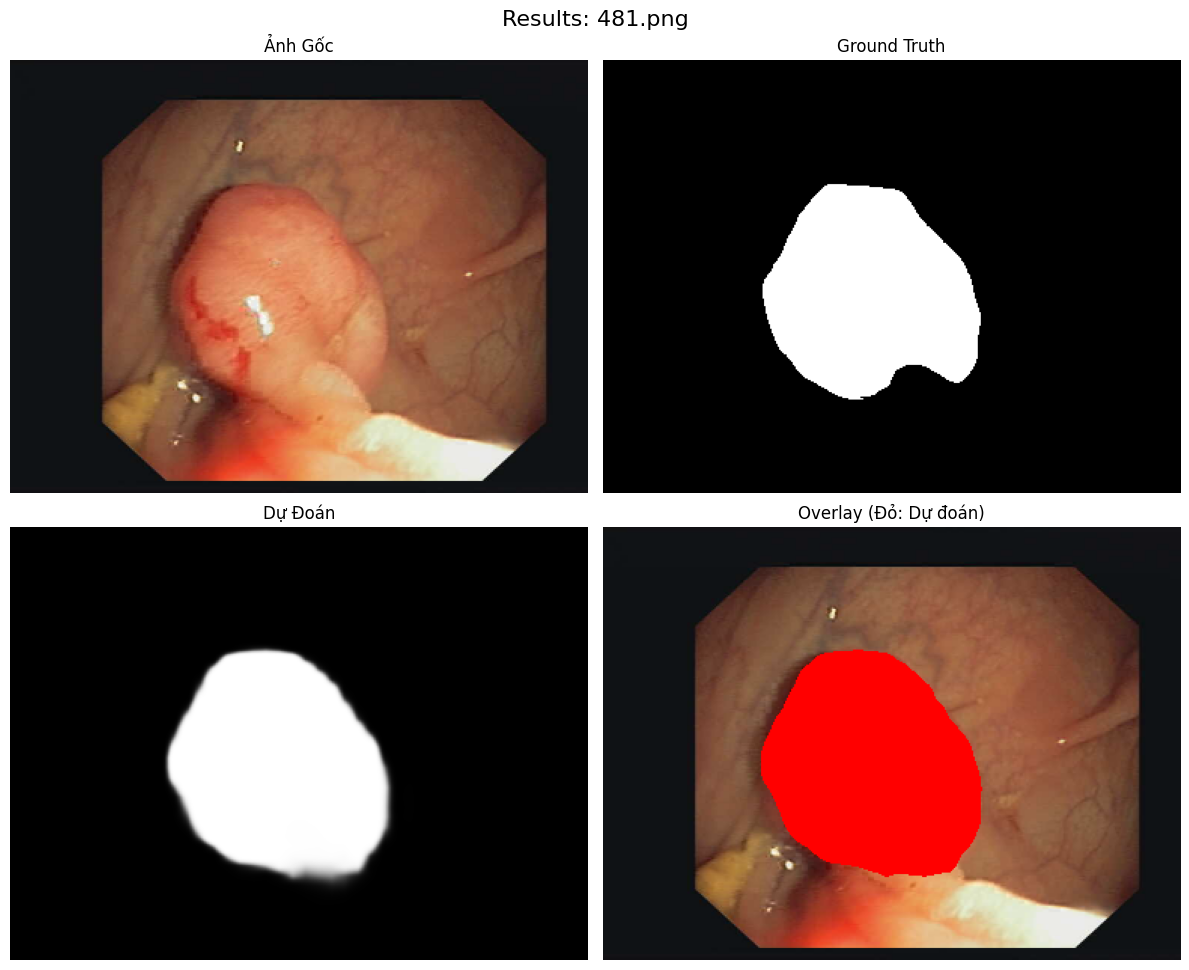

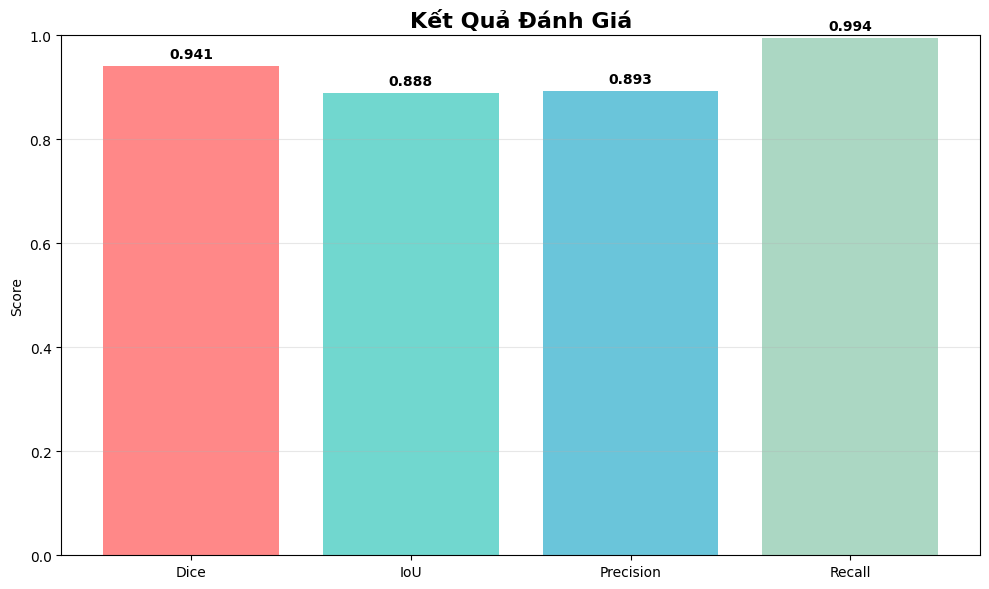

⏱️ Thời gian inference: 0.842 giây

------------------------------

📁 DATASET: CVC-300
🎲 Đang chọn ngẫu nhiên ảnh từ dataset: CVC-300...
📷 Ảnh được chọn: 195.png
🎯 Mask tương ứng: 195.png
📊 Metrics:
   Dice: 0.8828
   IoU: 0.7902
   Precision: 0.7952
   Recall: 0.9922


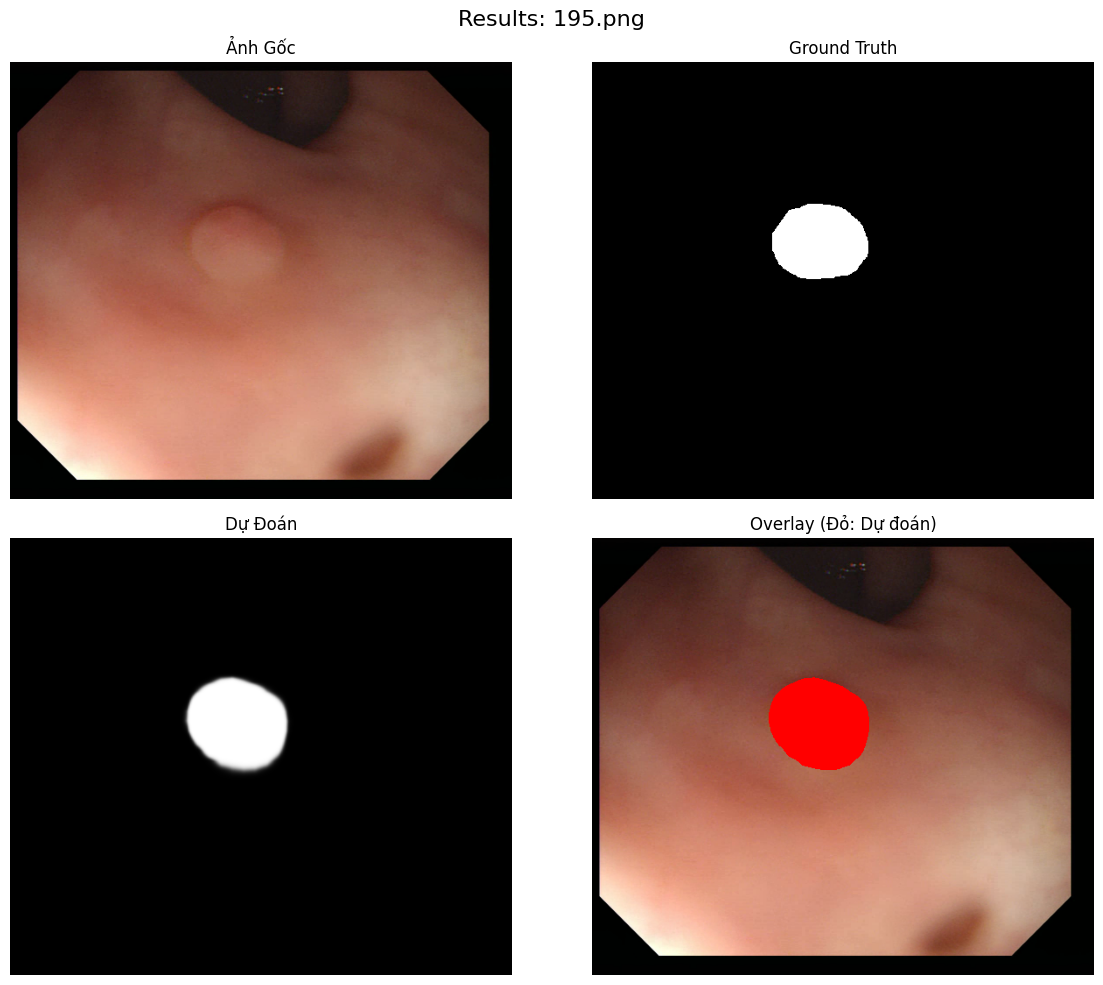

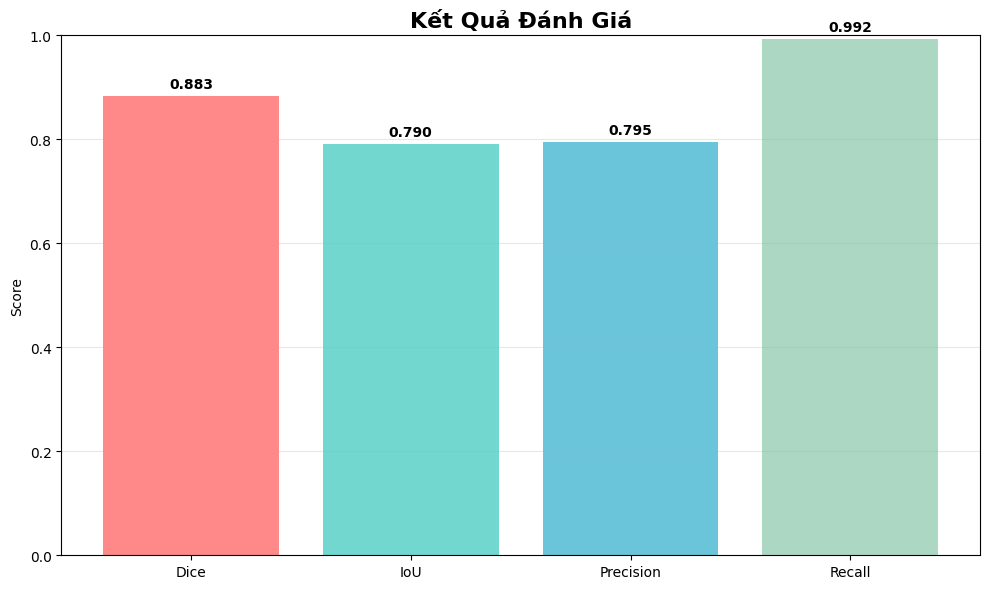

⏱️ Thời gian inference: 1.110 giây

------------------------------

🏆 TÓM TẮT KẾT QUẢ:
Dataset              Dice     IoU      Precision  Recall  
------------------------------------------------------------
Kvasir               0.697    0.535    0.952      0.550   
ETIS-LaribPolypDB    0.700    0.538    0.971      0.547   
CVC-ColonDB          0.814    0.686    0.725      0.928   
CVC-ClinicDB         0.941    0.888    0.893      0.994   
CVC-300              0.883    0.790    0.795      0.992   


In [18]:
all_results = test_random_from_all_datasets()